In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

ee.Initialize()

%load_ext autoreload
%autoreload 2

In [9]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_inflow(stid, startdate, enddate):
    '''
    Fetch the daily reservoir inflow for a CDEC reservoir ID
    Input: stid (str) - 3 letter station id (ex: ISB)
    Output: Sres - (pd.DataFrame) - the full monthly flow (km^3 / mon)
    '''
    # Download Storage (SensorNums = 65) data by query str:
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    url = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01'''.format(stid)
    print(url)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    inflow = pd.to_numeric(df.VALUE, errors='coerce')
    indf = pd.DataFrame(zip(dt_idx,inflow* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return rs.col_to_dt(indf)


def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def get_error_stats(preds,obs):
    
    A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

    solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
    m, c = solution[0]
    residuals = solution[1]

    # Calc RMSE 
    rmse = float(np.sqrt(np.mean((obs - preds)**2)))
    print(rmse)
    
    # Calc MAE
    mae = np.mean(abs(predictions - test_y))

    # Calc R^2    
    r2 = float(1 - residuals / sum((obs - obs.mean())**2))

    # Calc ubRMSE
    ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

    # Calc Bias 
    bias = float(np.mean(obs - preds))
    
    print(r2, rmse,ubrmse,bias)
    
    return [mae, rmse, r2, ubrmse, bias, m, c,]


In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '2003-09-30'
enddate = '2018-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

0
************************************************************
ENG YUBA R


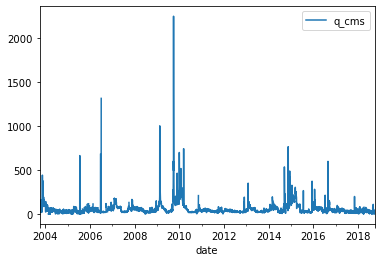

100%|██████████| 6210/6210 [10:48<00:00,  9.58it/s]  


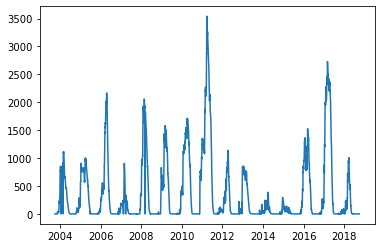

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 18.46 cms
Variable:                 4669 Importance: 0.653043261
Variable: 4669_t_1             Importance: 0.117851646
Variable: 2975_t_2             Importance: 0.004083498
Variable: 2891_t_1             Importance: 0.003793587
Variable:                 2791 Importance: 0.003026246
Variable:                 2512 Importance: 0.002895394
Variable: 3099_t_1             Importance: 0.002584626
Variable:                 3002 Importance: 0.0023009
Variable:                 3729 Importance: 0.002216006
Variable: 2248_t_1             Importance: 0.002029317
53.7285504128529
0.5494951766166765 53.7285504128529 53.57432002219491 -4.068090906791653


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


1
************************************************************
PAR MOKELUMNE R


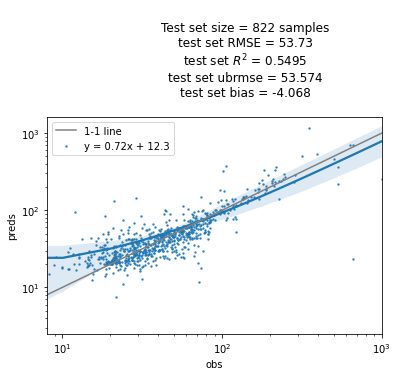

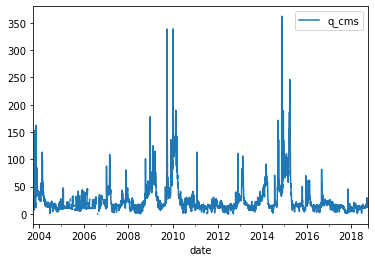

100%|██████████| 6210/6210 [05:37<00:00, 18.38it/s]


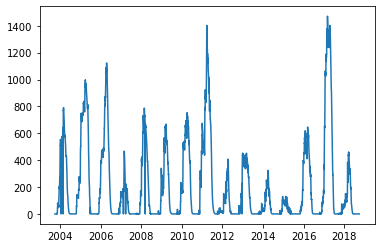

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 4.01 cms
Variable:                 2075 Importance: 0.866696084
Variable: 2075_t_1             Importance: 0.032559303
Variable: 90_t_1               Importance: 0.001399738
Variable: 81_t_2               Importance: 0.001032965
Variable: 32_t_2               Importance: 0.001026926
Variable: 14_t_2               Importance: 0.000975653
Variable: 57_t_2               Importance: 0.000895126
Variable: 907_t_2              Importance: 0.000803594
Variable: 90_t_2               Importance: 0.000655444
Variable: 0_t_2                Importance: 0.000646169
8.646162365328227
0.8766047501032836 8.646162365328227 8.625506299949365 -0.5972978462643223


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


2
************************************************************
MIL SAN JOAQUIN R


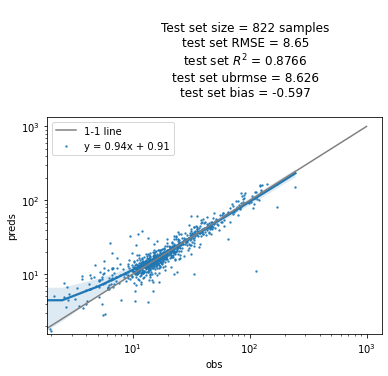

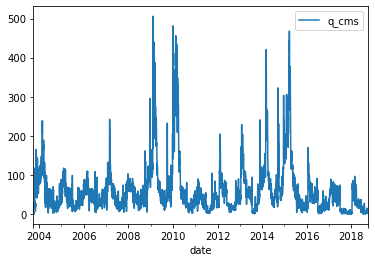

100%|██████████| 6210/6210 [06:40<00:00, 15.51it/s]


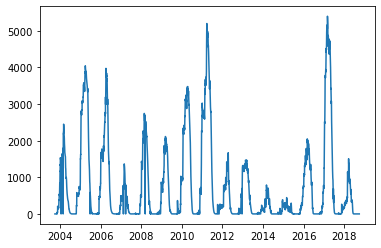

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 10.4 cms
Variable:                 6171 Importance: 0.933770716
Variable: 6171_t_1             Importance: 0.012681539
Variable:                 3387 Importance: 0.000264041
Variable: 2973_t_2             Importance: 0.000248047
Variable: 3113_t_1             Importance: 0.000192588
Variable: 4798_t_2             Importance: 0.000191059
Variable:                 4021 Importance: 0.000190471
Variable: 2294_t_2             Importance: 0.000168562
Variable:                 3376 Importance: 0.000164683
Variable: 3110_t_1             Importance: 0.000158532
17.75440764641836
0.92637327810755 17.75440764641836 17.72602808376665 -1.0034536604720663


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


3
************************************************************
ISB KERN R


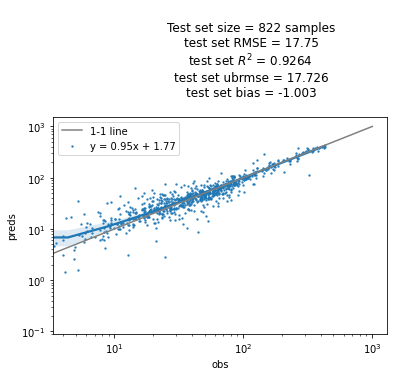

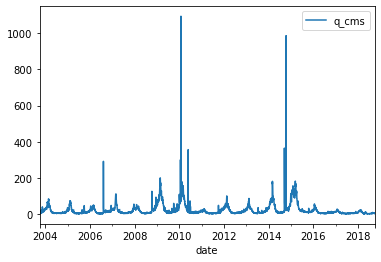

100%|██████████| 6210/6210 [09:32<00:00, 10.84it/s]


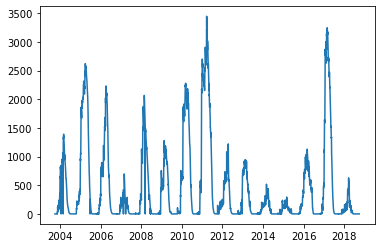

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 6.79 cms
Variable:                 7667 Importance: 0.801839355
Variable: 7667_t_1             Importance: 0.043833951
Variable: 3417_t_1             Importance: 0.004704652
Variable: 2854_t_1             Importance: 0.004443177
Variable:                 6332 Importance: 0.003602469
Variable: 3428_t_1             Importance: 0.003383994
Variable:                 6752 Importance: 0.003341923
Variable: 5910_t_1             Importance: 0.003190943
Variable: 3241_t_1             Importance: 0.003134832
Variable: 7292_t_1             Importance: 0.003132246
52.71997536814069
0.20881037834363092 52.71997536814069 52.690975132245825 1.7484114019338277


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


4
************************************************************
DNP TUOLUMNE R


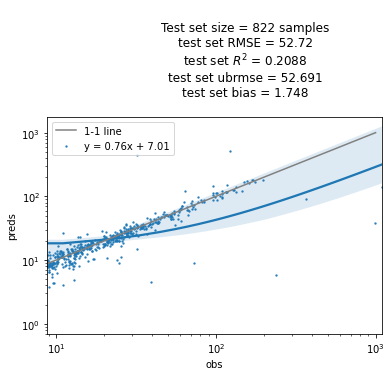

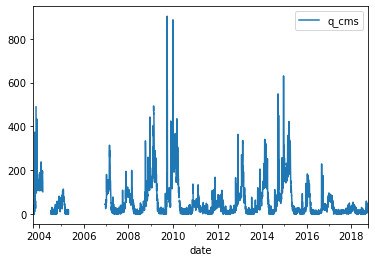

100%|██████████| 6210/6210 [06:48<00:00, 15.21it/s]


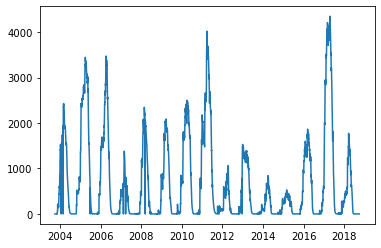

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 13.66 cms
Variable:                 5812 Importance: 0.822042877
Variable: 5812_t_1             Importance: 0.047450753
Variable:                 5483 Importance: 0.002439866
Variable:                   22 Importance: 0.000701517
Variable:                 5501 Importance: 0.000582057
Variable: 1841_t_1             Importance: 0.000576866
Variable:                  780 Importance: 0.000551168
Variable: 2376_t_1             Importance: 0.000516904
Variable: 332_t_1              Importance: 0.000502169
Variable:                 3668 Importance: 0.000483665
28.370056753759545

<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))



0.8635062659490796 28.370056753759545 28.219994473450686 -2.9141091485993216
5
************************************************************
NML STANISLAUS R


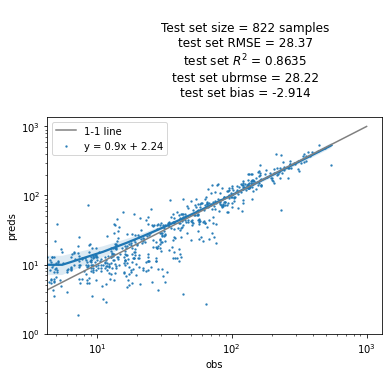

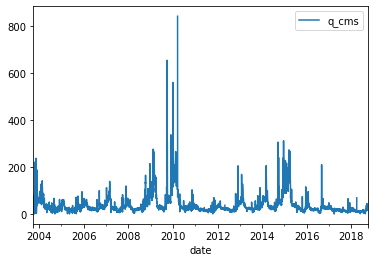

100%|██████████| 6210/6210 [07:47<00:00, 13.28it/s]


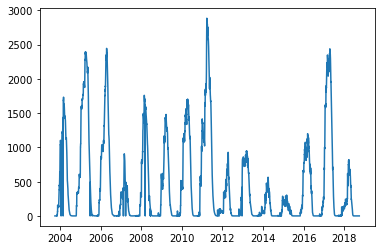

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 8.28 cms
Variable:                 3451 Importance: 0.775909189
Variable: 3451_t_1             Importance: 0.037127776
Variable: 1093_t_1             Importance: 0.004631519
Variable:                 2738 Importance: 0.003757376
Variable: 977_t_1              Importance: 0.001983466
Variable:                 2462 Importance: 0.001802561
Variable:                  507 Importance: 0.001796259
Variable:                 1499 Importance: 0.001732505
Variable: 863_t_2              Importance: 0.001635498
Variable:                 3025 Importance: 0.001608928
18.418032510942123
0.7940339662994462 18.418032510942123 18.177243291428116 -2.968458842287107


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


6
************************************************************
ORO FEATHER R


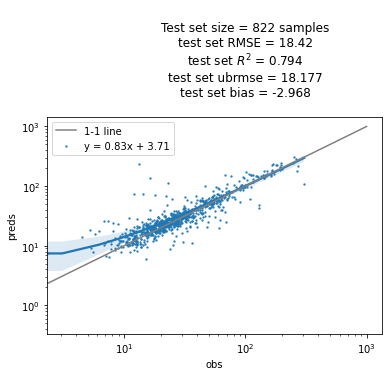

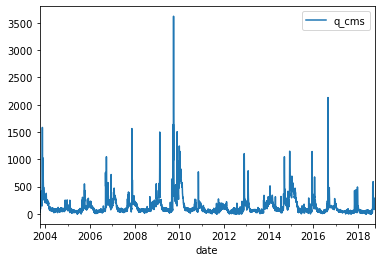

100%|██████████| 6210/6210 [09:26<00:00, 10.97it/s]


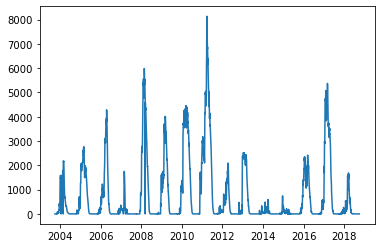

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 34.8 cms
Variable:                14058 Importance: 0.830759984
Variable: 14058_t_1            Importance: 0.078205696
Variable:                 6891 Importance: 0.001255133
Variable:                10579 Importance: 0.000963523
Variable:                  192 Importance: 0.000597114
Variable:                  247 Importance: 0.000584422
Variable:                  231 Importance: 0.000575074
Variable: 6295_t_2             Importance: 0.000568465
Variable: 7045_t_1             Importance: 0.000535393
Variable:                10225 Importance: 0.000490424
83.18438371686248
0.7423939491526129 83.18438371686248 82.91264460325152 -6.718263112525553


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


7
************************************************************
FOL AMERICAN R


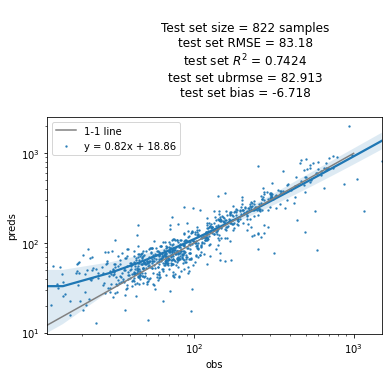

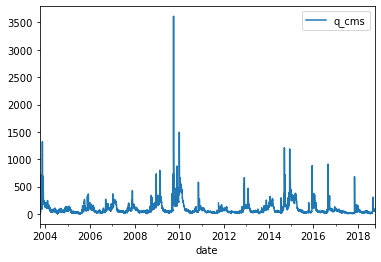

100%|██████████| 6210/6210 [07:47<00:00, 13.28it/s]


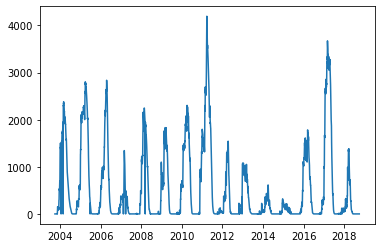

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 20.02 cms
Variable:                 7195 Importance: 0.870812178
Variable: 7195_t_1             Importance: 0.034750667
Variable:                  508 Importance: 0.001672196
Variable: 1372_t_1             Importance: 0.001274822
Variable:                 3810 Importance: 0.001269899
Variable: 4844_t_1             Importance: 0.000743991
Variable: 1455_t_1             Importance: 0.000596022
Variable: 2353_t_1             Importance: 0.000581273
Variable:                 1281 Importance: 0.000577567
Variable: 1040_t_1             Importance: 0.000532123
46.96048212983698
0.8192378439705164 46.96048212983698 46.68700293635087 -5.060695474725058


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


8
************************************************************
TRM KAWEAH R


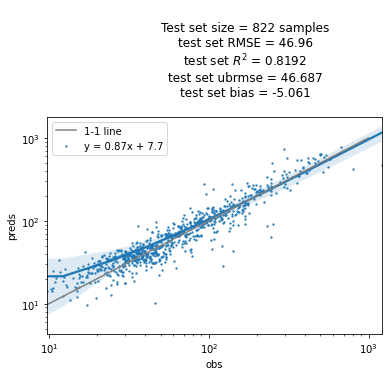

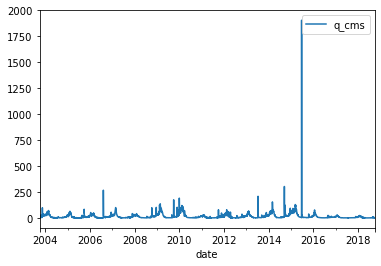

100%|██████████| 6210/6210 [09:04<00:00, 11.41it/s]


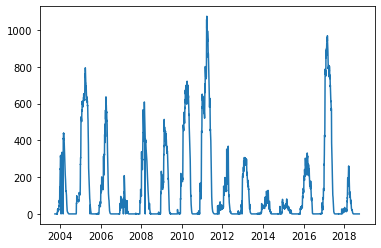

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 4.78 cms
Variable:                 2096 Importance: 0.727313633
Variable: 2096_t_1             Importance: 0.190053611
Variable: 174_t_1              Importance: 0.005325671
Variable:                  994 Importance: 0.004817298
Variable: 1617_t_1             Importance: 0.004699206
Variable: 753_t_2              Importance: 0.004232585
Variable: 2079_t_2             Importance: 0.004195587
Variable: 453_t_2              Importance: 0.003949192
Variable: 91_t_2               Importance: 0.003898966
Variable: 40_t_2               Importance: 0.003744274
47.87407954928024
0.09251126375019725 47.87407954928024 47.844775344839874 -1.674802941427923


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


9
************************************************************
SCC TULE R


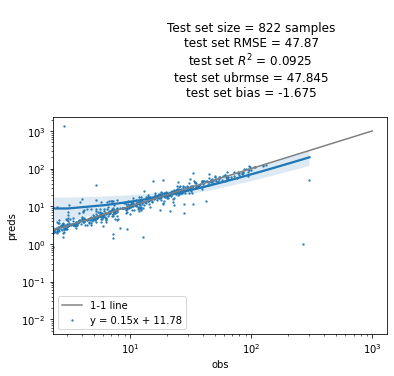

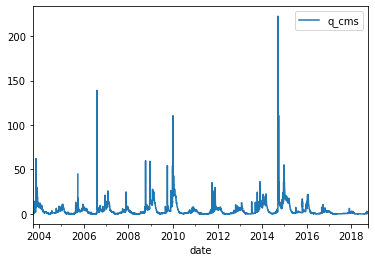

100%|██████████| 6210/6210 [04:24<00:00, 23.44it/s]


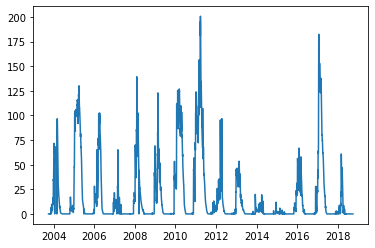

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 1.41 cms
Variable:                 1455 Importance: 0.842463261
Variable: 1455_t_1             Importance: 0.072513438
Variable:                   40 Importance: 0.005466716
Variable:                  251 Importance: 0.00126935
Variable:                  213 Importance: 0.001131528
Variable: 1435_t_1             Importance: 0.00109731
Variable: 222_t_2              Importance: 0.000955247
Variable: 1436_t_1             Importance: 0.000789769
Variable:                  118 Importance: 0.000705224
Variable:                  978 Importance: 0.000694653
8.190134273866006
0.3933533143699265 8.190134273866006 8.190120039142004 0.015269852625721806


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


10
************************************************************
CFW BEAR R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=CFW&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for CFW
11
************************************************************
PNF KINGS R


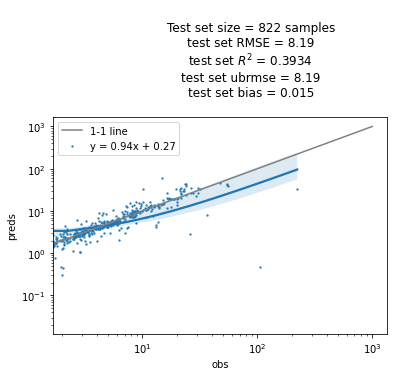

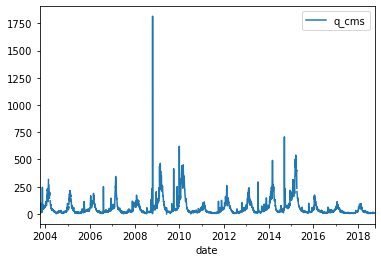

100%|██████████| 6210/6210 [07:54<00:00, 13.10it/s]


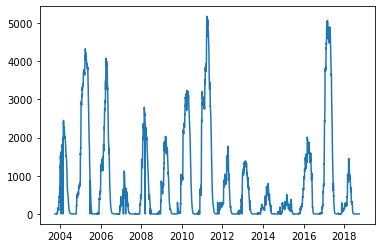

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 8.96 cms
Variable:                 5806 Importance: 0.860218177
Variable: 5806_t_1             Importance: 0.084053012
Variable: 2680_t_2             Importance: 0.001637284
Variable: 3702_t_1             Importance: 0.001318799
Variable: 1896_t_2             Importance: 0.001136293
Variable:                 5786 Importance: 0.000526463
Variable: 1768_t_2             Importance: 0.000260873
Variable: 2258_t_1             Importance: 0.000258772
Variable: 667_t_1              Importance: 0.00023676
Variable: 1728_t_2             Importance: 0.000231341
26.829866098632092
0.86200511298918

<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


 26.829866098632092 26.80175792263497 -1.2277976734793168
12
************************************************************
MCR MERCED R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MCR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for MCR
13
************************************************************
NHG CALAVERAS R


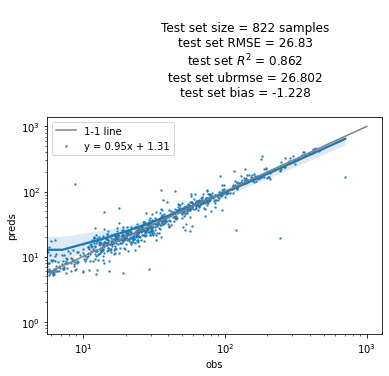

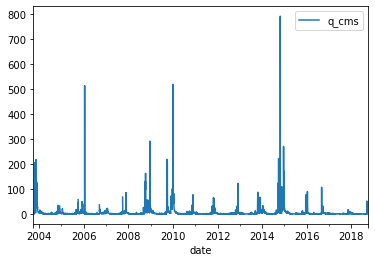

100%|██████████| 6210/6210 [06:32<00:00, 15.81it/s] 


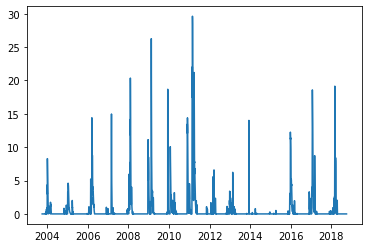

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 3.25 cms
Variable:                 1394 Importance: 0.465151432
Variable: 1394_t_1             Importance: 0.244229456
Variable:                   93 Importance: 0.013913051
Variable:                  133 Importance: 0.012797854
Variable: 325_t_2              Importance: 0.008510499
Variable: 131_t_1              Importance: 0.007855809
Variable: 912_t_2              Importance: 0.007526578
Variable: 758_t_2              Importance: 0.007114689
Variable: 617_t_2              Importance: 0.007091476
Variable: 378_t_2              Importance: 0.00690396
12.555394051115025
0.4970196917839691 12.555394051115025 12.479689559926447 -1.3766874251758823


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


14
************************************************************
SHA SACRAMENTO R


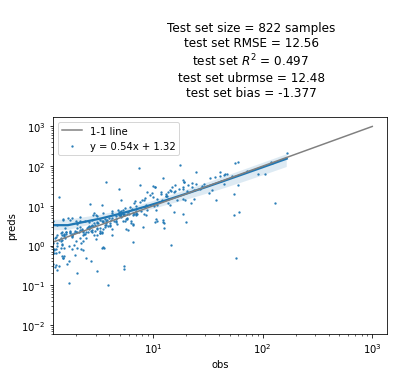

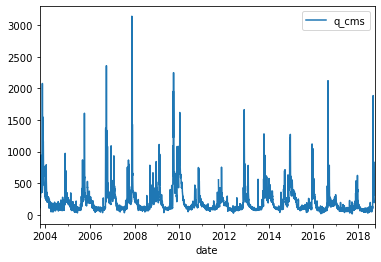

100%|██████████| 6210/6210 [13:32<00:00,  7.64it/s]


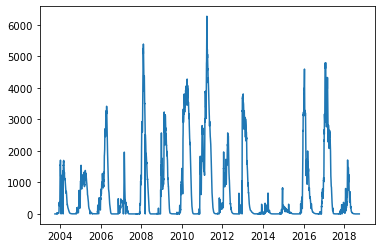

Running Random Forest...
5480 5478
4656 822 4656 822
Mean Absolute Error: 39.53 cms
Variable:                26799 Importance: 0.845364576
Variable: 26799_t_1            Importance: 0.034526426
Variable: 5502_t_2             Importance: 0.004461091
Variable:                 5742 Importance: 0.00367256
Variable: 5275_t_1             Importance: 0.002387135
Variable: 5502_t_1             Importance: 0.002204381
Variable: 5275_t_2             Importance: 0.001662145
Variable:                 5502 Importance: 0.001645062
Variable:                 5275 Importance: 0.001592539
Variable: 5742_t_1             Importance: 0.00134551


<ipython-input-9-4a63d42893c2>:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))


112.14164059915068
0.7197564001402699 112.14164059915068 112.08852775666645 -3.4510145772068386


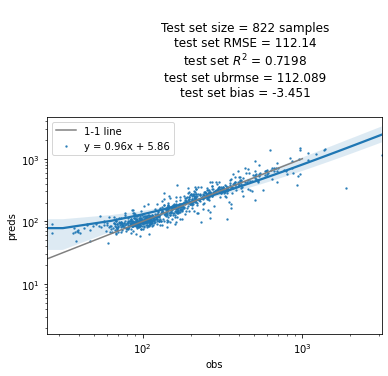

In [23]:
for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])

    # Get the daily reservoir inflow
    outfn = os.path.join('../data/{}_res.csv'.format(stn_id))
    if not os.path.exists(outfn):
        try:
            inflow = get_res_inflow(stn_id, startdate, enddate)
            inflow[inflow<0] = 0
            inflow.plot()
            inflow.to_csv(outfn)
            plt.show()
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(outfn))
        inflow[inflow<0] = 0
        inflow.plot()
        plt.show()
        
        
    # Get the SWE
    catch_shp = "../shape/{}.shp".format(stn_id)
    swe = get_snodas_swe(catch_shp, startdate, enddate)
    swestack = np.dstack(list(swe.values()))
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)
    plt.plot(dt_idx, [np.nansum(x) for x in swe.values()])
    plt.show()
    
    # Format for pxlwise xcorr 
    print("Running Random Forest...")
    
    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = dswe[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(ts_arr)
                rclist.append([row,col])

    # Make df from pixelwise timeseries
    pxdf = pd.DataFrame(px_ts).T
    pxdf.index = dt_idx[1:]
    pxdf.columns = pxdf.columns.map(str)

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Add teh lags 
    lags = range(1, 3) 
    mdf_lagged = mdf.assign(**{'{}_t_{}'.format(col, t): mdf[col].shift(t) for t in lags for col in mdf})
    
    # Fill infs with 0
    mldf = mdf_lagged[len(lags):].fillna(0)
#     mldf = mdf_lagged[len(lags):][~mdf_lagged[len(lags):].isin([np.nan, np.inf, -np.inf]).any(1)]
#     print(len(mdf), len(mldf))

    # Run the Random Forest
    target = 'q_cms'    
    labels = np.array(mldf[target])
    feature_list = list(mldf.columns)
    features = np.array(mldf.drop(target, axis = 1))

    train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size = 0.15, random_state = 42)

    print(len(train_X), len(test_X), len(train_y), len(test_y))
    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(train_X, train_y);

    predictions = rf.predict(test_X)
    errors = abs(predictions - test_y)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'cms')

    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 9)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
#     [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];

    preds = predictions.copy()
    obs = test_y.copy()
    
    rmse, mae, r2, ubrmse, bias, m, c = get_error_stats(preds,obs)

    outdf = pd.DataFrame([preds,obs]).T
    outdf.columns = ['preds','obs']

    ax = sns.regplot(x="obs", y="preds", data=outdf,scatter_kws={'s':2}, ci = 99, 
                     label='y = {}x + {}'.format(round(float(m),2), round(float(c),2)))
    ax.set(xscale="log", yscale="log")
    ax.plot([-10, 1e3], [-10, 1e3], "gray", label = "1-1 line")
    ax.legend()
    ax.set_title('''
                Test set size = {} samples
                test set MAE = {}
                test set RMSE = {}
                test set $R^2$ = {}
                test set ubrmse = {}
                test set bias = {}
                '''.format(len(preds), round(float(mae),2), round(float(rmse),2), round(float(r2),4), round(float(ubrmse),3), round(float(bias),3)))
    plt.show()
    
    results_dir = "../data/results"
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    
    outfn = os.path.join(results_dir,stn_id+".csv")
    outdf.to_csv(outfn)
    

In [25]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 9)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_s = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [38]:
impdict = dict(zip(feature_list, importances))

In [51]:
# Build the out image
outim = np.zeros_like(np.mean(swestack, axis = 2))
pxdf.columns = pxdf.columns.map(str)

In [53]:

# Populate the per-pixel lags 
for rc, dfcolidx in zip(rclist,pxdf.columns):
    print(dfcolidx)
    colmatchlist = [x + ]
    
    pxkeys = [x for x in [str(y) for y in impdict.keys()] if dfcolidx == x]
    print(pxkeys)
#     rowidx, colidx = rc
#     val = lagdf[dfcolidx].values[0]
#     lagim[rowidx,colidx] = val

0
['0']
1
['1']
2
['2']
3
['3']
4
['4']
5
['5']
6
['6']
7
['7']
8
['8']
9
['9']
10
['10']
11
['11']
12
['12']
13
['13']
14
['14']
15
['15']
16
['16']
17
['17']
18
['18']
19
['19']
20
['20']
21
['21']
22
['22']
23
['23']
24
['24']
25
['25']
26
['26']
27
['27']
28
['28']
29
['29']
30
['30']
31
['31']
32
['32']
33
['33']
34
['34']
35
['35']
36
['36']
37
['37']
38
['38']
39
['39']
40
['40']
41
['41']
42
['42']
43
['43']
44
['44']
45
['45']
46
['46']
47
['47']
48
['48']
49
['49']
50
['50']
51
['51']
52
['52']
53
['53']
54
['54']
55
['55']
56
['56']
57
['57']
58
['58']
59
['59']
60
['60']
61
['61']
62
['62']
63
['63']
64
['64']
65
['65']
66
['66']
67
['67']
68
['68']
69
['69']
70
['70']
71
['71']
72
['72']
73
['73']
74
['74']
75
['75']
76
['76']
77
['77']
78
['78']
79
['79']
80
['80']
81
['81']
82
['82']
83
['83']
84
['84']
85
['85']
86
['86']
87
['87']
88
['88']
89
['89']
90
['90']
91
['91']
92
['92']
93
['93']
94
['94']
95
['95']
96
['96']
97
['97']
98
['98']
99
['99']
100
['100']
101
['10

['702']
703
['703']
704
['704']
705
['705']
706
['706']
707
['707']
708
['708']
709
['709']
710
['710']
711
['711']
712
['712']
713
['713']
714
['714']
715
['715']
716
['716']
717
['717']
718
['718']
719
['719']
720
['720']
721
['721']
722
['722']
723
['723']
724
['724']
725
['725']
726
['726']
727
['727']
728
['728']
729
['729']
730
['730']
731
['731']
732
['732']
733
['733']
734
['734']
735
['735']
736
['736']
737
['737']
738
['738']
739
['739']
740
['740']
741
['741']
742
['742']
743
['743']
744
['744']
745
['745']
746
['746']
747
['747']
748
['748']
749
['749']
750
['750']
751
['751']
752
['752']
753
['753']
754
['754']
755
['755']
756
['756']
757
['757']
758
['758']
759
['759']
760
['760']
761
['761']
762
['762']
763
['763']
764
['764']
765
['765']
766
['766']
767
['767']
768
['768']
769
['769']
770
['770']
771
['771']
772
['772']
773
['773']
774
['774']
775
['775']
776
['776']
777
['777']
778
['778']
779
['779']
780
['780']
781
['781']
782
['782']
783
['783']
784
['784']
785
['78

['1337']
1338
['1338']
1339
['1339']
1340
['1340']
1341
['1341']
1342
['1342']
1343
['1343']
1344
['1344']
1345
['1345']
1346
['1346']
1347
['1347']
1348
['1348']
1349
['1349']
1350
['1350']
1351
['1351']
1352
['1352']
1353
['1353']
1354
['1354']
1355
['1355']
1356
['1356']
1357
['1357']
1358
['1358']
1359
['1359']
1360
['1360']
1361
['1361']
1362
['1362']
1363
['1363']
1364
['1364']
1365
['1365']
1366
['1366']
1367
['1367']
1368
['1368']
1369
['1369']
1370
['1370']
1371
['1371']
1372
['1372']
1373
['1373']
1374
['1374']
1375
['1375']
1376
['1376']
1377
['1377']
1378
['1378']
1379
['1379']
1380
['1380']
1381
['1381']
1382
['1382']
1383
['1383']
1384
['1384']
1385
['1385']
1386
['1386']
1387
['1387']
1388
['1388']
1389
['1389']
1390
['1390']
1391
['1391']
1392
['1392']
1393
['1393']
1394
['1394']
1395
['1395']
1396
['1396']
1397
['1397']
1398
['1398']
1399
['1399']
1400
['1400']
1401
['1401']
1402
['1402']
1403
['1403']
1404
['1404']
1405
['1405']
1406
['1406']
1407
['1407']
1408
['1408

['1930']
1931
['1931']
1932
['1932']
1933
['1933']
1934
['1934']
1935
['1935']
1936
['1936']
1937
['1937']
1938
['1938']
1939
['1939']
1940
['1940']
1941
['1941']
1942
['1942']
1943
['1943']
1944
['1944']
1945
['1945']
1946
['1946']
1947
['1947']
1948
['1948']
1949
['1949']
1950
['1950']
1951
['1951']
1952
['1952']
1953
['1953']
1954
['1954']
1955
['1955']
1956
['1956']
1957
['1957']
1958
['1958']
1959
['1959']
1960
['1960']
1961
['1961']
1962
['1962']
1963
['1963']
1964
['1964']
1965
['1965']
1966
['1966']
1967
['1967']
1968
['1968']
1969
['1969']
1970
['1970']
1971
['1971']
1972
['1972']
1973
['1973']
1974
['1974']
1975
['1975']
1976
['1976']
1977
['1977']
1978
['1978']
1979
['1979']
1980
['1980']
1981
['1981']
1982
['1982']
1983
['1983']
1984
['1984']
1985
['1985']
1986
['1986']
1987
['1987']
1988
['1988']
1989
['1989']
1990
['1990']
1991
['1991']
1992
['1992']
1993
['1993']
1994
['1994']
1995
['1995']
1996
['1996']
1997
['1997']
1998
['1998']
1999
['1999']
2000
['2000']
2001
['2001

KeyboardInterrupt: 

In [54]:
feature_list

['q_cms',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 1